# Probabilistic Linear Discriminant Analysis (PLDA)

This notebook illustrate how to build and train a PLDA model.

In [4]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using ExpFamilyDistributions
using Random

using Revise
using BayesianModels

using BasicDataLoaders

# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1278


## Synethic data

Our toy data is simply samples from a 2-dimensional Normal distribution

In [5]:
T = Float64
μ₁ = T[1, 1] 
μ₂ = T[0, 0]
μ₃ = T[-1, -1]
Σ = T[2. -.7; -.7  0.3]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

x1 = draw(20, μ₁, Σ)
x2 = draw(20, μ₂, Σ)
x3 = draw(20, μ₃, Σ)
X = vcat(x1, x2, x3)
z1 = ones(Int64, 20)
z2 = 2*ones(Int64, 20)
z3 = 3*ones(Int64, 20)
z = vcat(z1, z2, z3)

data = [y for y in zip(X, z)]

#scatter(getindex.(x1, 1), getindex.(x1, 2), color = :blue, legend = false)
#scatter!(getindex.(x2, 1), getindex.(x2, 2), color = :red)
#scatter!(getindex.(x3, 1), getindex.(x3, 2), color = :green)
dl = DataLoader(data, batchsize = 10, preprocess = (b) -> (getindex.(b, 1), getindex.(b, 2)))

DataLoader{Array{Tuple{Array{Float64,1},Int64},1}}
  data: Array{Tuple{Array{Float64,1},Int64},1}
  batchsize: 10

## Model

In [6]:
Q1 = 2
Q2 = 2
K = 3

# Within class model
plda = PLDA(T, datadim = 2, latentdim_within_class = Q1, 
              latentdim_across_class = Q2, pstrength = 1e-3,
            W_MAP = true)
uposts = Dict(k => Normal(randn(T, Q2)) for k in 1:K)

Dict{Int64,Normal{Float64,2}} with 3 entries:
  2 => Normal{Float64,2}([1.05934, -0.658071], [1.0 0.0; 0.0 1.0])
  3 => Normal{Float64,2}([0.905431, 0.524145], [1.0 0.0; 0.0 1.0])
  1 => Normal{Float64,2}([-0.182544, 0.218168], [1.0 0.0; 0.0 1.0])

In [7]:
function monitor(epoch)
    ND = length(X) * length(X[1])
    𝓛 = elbo(plda, X, z, uposts) / ND
    println("epoch: $epoch 𝓛 = $𝓛")
end

fit!(plda, dl, uposts, epochs = 100, callback = monitor)

epoch: 1 𝓛 = -1.888003500039093
epoch: 2 𝓛 = -1.6128898822914564
epoch: 3 𝓛 = -1.390584679899421
epoch: 4 𝓛 = -1.2887551062857494
epoch: 5 𝓛 = -1.2194362306393345
epoch: 6 𝓛 = -1.174952815870485
epoch: 7 𝓛 = -1.1500775775814924
epoch: 8 𝓛 = -1.1374333577670082
epoch: 9 𝓛 = -1.1310301138117225
epoch: 10 𝓛 = -1.1274402488971054
epoch: 11 𝓛 = -1.1250690975550826
epoch: 12 𝓛 = -1.1232517324893825
epoch: 13 𝓛 = -1.1217364662715383
epoch: 14 𝓛 = -1.120453218994592
epoch: 15 𝓛 = -1.1194022081677815
epoch: 16 𝓛 = -1.1185834837797652
epoch: 17 𝓛 = -1.1179628855085122
epoch: 18 𝓛 = -1.1174827761126338
epoch: 19 𝓛 = -1.117089863390734
epoch: 20 𝓛 = -1.1167486785008054
epoch: 21 𝓛 = -1.1164394447913877
epoch: 22 𝓛 = -1.1161517191725812
epoch: 23 𝓛 = -1.1158797130132316
epoch: 24 𝓛 = -1.115619830886982
epoch: 25 𝓛 = -1.1153695453356758
epoch: 26 𝓛 = -1.1151269037692448
epoch: 27 𝓛 = -1.1148903064496798
epoch: 28 𝓛 = -1.1146583977008613
epoch: 29 𝓛 = -1.1144300054826215
epoch: 30 𝓛 = -1.114204102972

In [8]:
uposts

Dict{Int64,Normal{Float64,2}} with 3 entries:
  2 => Normal{Float64,2}([1.14518e-8, -0.0512982], [1.0 2.22533e-7; 2.22533e-7 …
  3 => Normal{Float64,2}([-3.39874e-7, 1.52246], [1.0 2.22533e-7; 2.22533e-7 0.…
  1 => Normal{Float64,2}([3.51538e-7, -1.57471], [1.0 2.22533e-7; 2.22533e-7 0.…

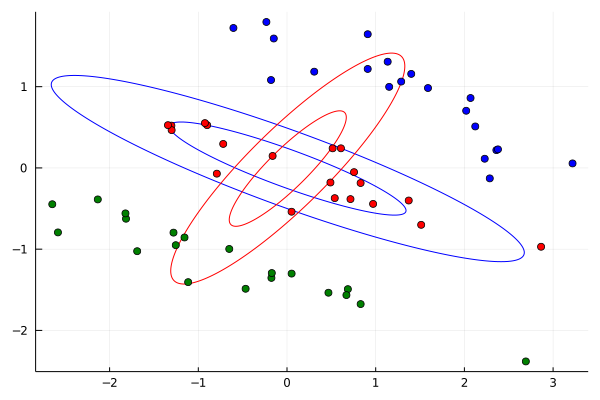

In [9]:
p = plot(legend = false)

λ = mean(model.λ.posterior)

W = hcat([w.posterior.μ for w in plda.trans_within_class.W]...)
m = W[end, :]
S = (1/λ) * Matrix{T}(I, 2, 2)
for d in 1:Q2
    w = W[1:end-1, :][d, :]
    w = w / norm(w)
    S += w * w'
end
plotnormal2d!(p, m, S, color = :blue)

W = hcat([w.posterior.μ for w in plda.trans_across_class.W]...)
m = W[end, :]
S = (1/λ) * Matrix{T}(I, 2, 2)
for d in 1:Q2
    w = W[1:end-1, :][d, :]
    #w = w / norm(w)
    S += w * w'
end
plotnormal2d!(p, m, S, color = :red)

scatter!(getindex.(x1, 1), getindex.(x1, 2), color = :blue)
scatter!(getindex.(x2, 1), getindex.(x2, 2), color = :red)
scatter!(getindex.(x3, 1), getindex.(x3, 2), color = :green)

In [10]:
plda.trans_across_class.W[2]

BayesParam{Normal{Float64,3},δNormal{Float64,3}}:
  prior: Normal{Float64,3}([0.0, 0.0, 0.0], [0.00099900099900687 0.0 0.0; 0.0 0.4176593124503055 0.0; 0.0 0.0 0.0010673566462641078])
  posterior: δNormal{Float64,3}([7.979764792275865e-8, -0.6722513491004484, -0.007825489942466152])


In [11]:
p = plot(legend = false)
plotnormal2d!(p, plda.trans_across_class.hprior.μ, plda.trans_across_class.hprior.Σ)
plotnormal2d!(p, uposts[1].μ, uposts[1].Σ, color = :blue)
plotnormal2d!(p, uposts[2].μ, uposts[2].Σ, color = :red)
plotnormal2d!(p, uposts[3].μ, uposts[3].Σ, color = :green)

LoadError: type AffineTransform has no field hprior

In [12]:
hposts = (X, z, uposts) |> plda

p = plot(legend = false)
plotnormal2d!(p, plda.trans_within_class.hprior.μ, plda.trans_across_class.hprior.Σ,
             color = :pink)
for post in hposts
    plotnormal2d!(p, post.μ, post.Σ)
end
p

LoadError: type AffineTransform has no field hprior

In [10]:
update_u!(plda, uposts, stats)

LoadError: MethodError: no method matching keys(::typeof(stats))
Closest candidates are:
  keys(!Matched::Cmd) at process.jl:638
  keys(!Matched::Core.SimpleVector) at essentials.jl:603
  keys(!Matched::LibGit2.GitTree) at /home/lucas/.julia/packages/Revise/BqeJF/src/git.jl:52
  ...

In [11]:
S₁, S₂ = hstats(plda.trans_across_class, X)

sum(S₁[z .== 1])

2-element Array{Float64,1}:
 26.15045188715152
 -4.911082697593531e-16

In [12]:
hposts = (X, z, μposts) |> plda

LoadError: UndefVarError: μposts not defined

In [7]:
λstats(plda, X, z, μposts, hposts)

LoadError: UndefVarError: λstats not defined

In [17]:
stats = wstats_within_class(plda, X, z, μposts, hposts)
update_W_within_class!(plda, stats)

In [18]:
stats = wstats_across_class(plda, X, z, μposts, hposts)
update_W_across_class!(plda, stats)

60-element Array{Normal{Float64,2},1}:
 Normal{Float64,2}([0.3079071205628463, 0.005742928715122844], [0.23691976361378805 -0.04451569555318613; -0.04451569555318613 0.28231490651946745])
 Normal{Float64,2}([0.2614220223240039, -0.01196224838370831], [0.23691976361378805 -0.04451569555318613; -0.04451569555318613 0.28231490651946745])
 Normal{Float64,2}([-0.21124943985251465, -0.6131469507646469], [0.23691976361378805 -0.04451569555318613; -0.04451569555318613 0.28231490651946745])
 Normal{Float64,2}([-0.04302191302862619, -0.29235142643418544], [0.23691976361378805 -0.04451569555318613; -0.04451569555318613 0.28231490651946745])
 Normal{Float64,2}([0.38636295113293256, 0.02297137974437631], [0.23691976361378805 -0.04451569555318613; -0.04451569555318613 0.28231490651946745])
 Normal{Float64,2}([0.18085497579593188, -0.09489275350136289], [0.23691976361378805 -0.04451569555318613; -0.04451569555318613 0.28231490651946745])
 Normal{Float64,2}([-0.049771801094679116, -0.42168979484580243

In [18]:
#mean.(μposts) |> model.trans_across_class
μs = mean.([μposts[zᵢ] for zᵢ in z]) |> model.trans_across_class
X - μs

60-element Array{Array{Float64,1},1}:
 [0.06925507050502888, 1.4157588236589886]
 [0.14946227398989254, 1.2480831495855746]
 [3.232674445340901, 0.6952424361334073]
 [1.5601283057268747, 0.599757174303583]
 [0.0020163563560936515, 1.7333715356990071]
 [0.5697776390319716, 1.100392291033254]
 [2.254336616696178, 0.9221995484229546]
 [0.8098134864848119, 1.046050993226033]
 [0.4142366216876512, 1.1123721461904699]
 [2.852775151121234, 0.757239763432259]
 [0.6948072210951923, 0.9858324675644095]
 [1.219613840237431, 0.7753267195770761]
 [0.46927230156267397, 1.1850314326674178]
 ⋮
 [-0.13728647552401685, -1.4404633399221212]
 [1.5259087436949708, -2.0960633421370165]
 [-0.9382744662693014, -0.7506591522631089]
 [-1.621455304779758, -0.9027334897364954]
 [-3.2133586946329156, -0.16346803394389997]
 [-2.495863195316364, -0.730353436699738]
 [-3.2494132411363044, -0.6103694882072552]
 [-0.8310318625416842, -0.7263535128469396]
 [-1.3868854620188027, -1.0096902040414495]
 [-3.858595184110105,

In [8]:
hposteriors(model2, X, z, μposts)

Dict{Int64,Normal{Float64,2}} with 3 entries:
  2 => Normal{Float64,2}([0.0569211, 0.194276], [0.193662 0.0120739; 0.0120739 …
  3 => Normal{Float64,2}([-2.8991, -0.489842], [0.193662 0.0120739; 0.0120739 0…
  1 => Normal{Float64,2}([2.81994, 0.395902], [0.193662 0.0120739; 0.0120739 0.…

In [22]:
hposts = hposteriors(model2, X, θposts2)
H = mean.(hposts)

60-element Array{Array{Float64,1},1}:
 [0.42780074162828086, -0.42665195596928407]
 [0.39847052811520867, -0.34452458238077716]
 [0.9820374271484467, 0.9336573715177028]
 [0.5506649144826482, 0.3663486212385154]
 [0.50379721102135, -0.5519507018845021]
 [0.45702382126913266, -0.14721750456525878]
 [0.811828934109281, 0.5116445217904981]
 [0.4991744874048435, -0.04410450207038013]
 [0.4229645823589794, -0.20662619025709464]
 [0.9083556086975209, 0.7781173271441832]
 [0.45393388595520384, -0.06600655700196624]
 [0.5194655122094798, 0.18867279978669851]
 [0.4573444375710385, -0.21012373582636654]
 ⋮
 [-0.45139255210871543, 0.4102149563195866]
 [-0.24036570439577093, 1.2136591593389563]
 [-0.4444053687441012, -0.09598960624003196]
 [-0.6534391224182797, -0.2916648384137685]
 [-0.8229671011426763, -1.0963060068667094]
 [-0.8144127702192139, -0.6591325833658511]
 [-0.9614329729269565, -0.9667007165000767]
 [-0.4114662731350106, -0.065411686561251]
 [-0.6278852847306301, -0.17372934345720212]

In [39]:
m = transform(model2, θposts2, hposts)

60-element Array{Array{Float64,1},1}:
 [-0.30485062094622895, 0.5595502397711515]
 [-0.2327862408814283, 0.472483854536127]
 [1.1513092512226957, -0.47761930366117616]
 [0.4934842126318907, -0.12303514772335566]
 [-0.40690889924367, 0.7045509862011414]
 [-0.027088385448658492, 0.3135447251719532]
 [0.6999980999122645, -0.1551799311267914]
 [0.08332525693985188, 0.23498016594588014]
 [-0.09317051589396282, 0.35500420836067903]
 [0.9822071805125875, -0.3630416452253425]
 [0.05071281204260254, 0.23753923042371436]
 [0.3136865758551345, 0.02847224310269844]
 [-0.08787664473052943, 0.37161172100484796]
 ⋮
 [0.2829908457884041, -0.5535959075824181]
 [1.1136851283768845, -1.2114742194184978]
 [-0.20505799634592814, -0.08461656532069176]
 [-0.44716110688491684, 0.014229181916393885]
 [-1.2685384554978167, 0.6893677931987264]
 [-0.8433623854018695, 0.29002335628543946]
 [-1.1780816064383401, 0.5160775714766015]
 [-0.16715577475601814, -0.09995651492278823]
 [-0.326594326172852, -0.0844502512748

In [41]:
X - m

60-element Array{Array{Float64,1},1}:
 [0.3741056914512578, 0.8562085838878372]
 [0.38224851487132083, 0.7755992950494477]
 [2.081365194118205, 1.1728617397945835]
 [1.0666440930949839, 0.7227923220269387]
 [0.40892525559976367, 1.0288205494978657]
 [0.5968660244806301, 0.7868475658613008]
 [1.5543385167839134, 1.077379479549746]
 [0.72648822954496, 0.8110708272801528]
 [0.507407137581614, 0.7573679378297908]
 [1.8705679706086467, 1.1202814086576014]
 [0.6440944090525897, 0.7482932371406951]
 [0.9059272643822965, 0.7468544764743776]
 [0.5571489462932034, 0.8134197116625699]
 ⋮
 [-0.42027732131242096, -0.8868674323397031]
 [0.41222361531808627, -0.8845891227185187]
 [-0.7332164699233733, -0.6660425869424171]
 [-1.1742941978948411, -0.9169626716528892]
 [-1.9448202391350988, -0.8528358271426264]
 [-1.6525008099144944, -1.0203767929851775]
 [-2.071331634697964, -1.1264470596838567]
 [-0.663876087785666, -0.6263969979241514]
 [-1.0602911358459508, -0.9252399527665887]
 [-2.2610460084062582

In [28]:
#M = hposteriors(model2, X, θposts2)

accstats = Dict{eltype(z), Tuple{eltype(X), Int64}}()
for (zᵢ, mᵢ) in zip(z, M)
    v, c = get(accstats, zᵢ, (zero(mᵢ), 0)) 
    accstats[zᵢ] = v + mᵢ, c + 1
end
accstats

Dict{Int64,Tuple{Array{Float64,1},Int64}} with 3 entries:
  2 => ([-2.52388, -0.313787], 20)
  3 => ([16.8923, 41.2301], 20)
  1 => ([-15.4746, -40.3206], 20)

## Training

The code below is only for plotting and it is not needed to use the model in practice. 

In [29]:
# Number of epochs for the training
epochs = 100

# For visualisation
anim = Animation()

# Training
elbos = []
function monitor(epoch)
    e = elbo(model, dl, θposts) 
    ND = length(X) * length(X[1])
    push!(elbos, e / ND)
    
    l = @layout [a b; c d]
    
    p1 = plot(legend = false, ylims = (-1,3), xlims = (-3, 5), title = "Observation space")
    scatter!(p1, getindex.(X, 1), getindex.(X, 2), mark = :cross, color = :blue)
    plotmodel!(p1, model, θposts)

    p3 = plot(xlabel = "epoch", xlims = (1, epochs), ylims = (-2, -1),
              color = :blue, legend = :bottomleft)
    plot!(p3, elbos,linewidth = 2, label = "ELBO")

    W = hcat([p.μ for p in θposts[:w]]...)
    w₁ = W[1:end-1,:][1, :]
    w₂ = W[1:end-1,:][2, :]
    p4 = bar(["||w₁||²", "||w₂||²"], [norm(w₁), norm(w₂)],  ylims = (0,3),
             legend = false, color = :black, title = "norm. bases")

    hposts = hposteriors(model, X, θposts)
    p2 = plot(legend = false, title = "Latent space", xlims = (-3, 3), ylims = (-3, 3))
    plotnormal2d!(p2, model.h.μ, model.h.Σ, color = :blue, linewidth = 2)
    plotnormals!(p2, hposts)

    plot(p1, p2, p3, p4, layout = l, size = (800, 500))
    
    frame(anim)
end

monitor (generic function with 1 method)

The actual training is done just by calling the function `fit!`. Note that `callback` is an optional argument and it is only for the user to monitor the convergence of the model. In this example, our callback is the `monitor` function which:
  * compute the ELBO of the data and the model
  * do some plotting  
  
This is of course time consuming and should be avoided in real cases. We recommend to use a simpler callback (if you want to use one) which computes the ELBO on a subset of the data every $K$ epochs. For instance, the callback can look like this:
```julia
function simplemonitor(epoch)
    # Compute the elbo every 5 epochs
    if epoch % 5 == 0 
        𝓛 = elbo(model, dl, θposts) 
        println("epoch = $e  𝓛 = $𝓛")
    end
end

fit!(model, dl, θposts, epochs = epochs, callback = simplemonitor)
```

┌ Info: Saved animation to 
│   fn = /home/lucas/GithubRepositories/PPCA/examples/demo.gif
└ @ Plots /home/lucas/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/home/lucas/GithubRepositories/PPCA/examples/demo.gif")
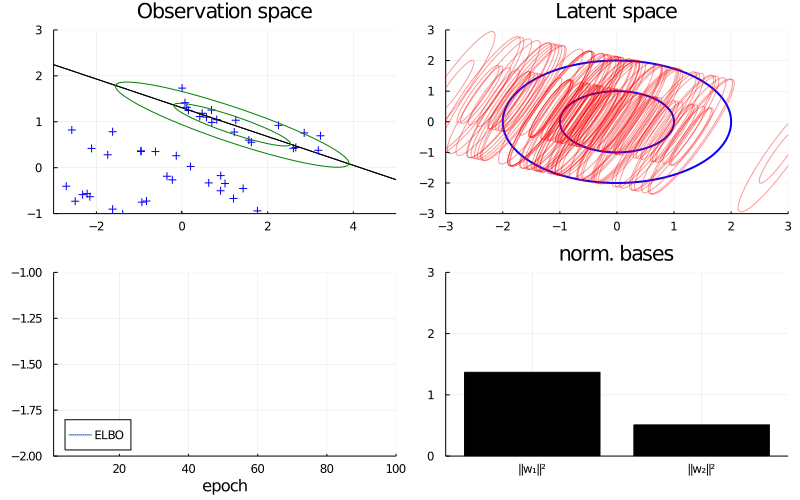

In [31]:
monitor(0) # Just to add the ini₁lization of the model to the animation

# Training
# Internally, this function uses functionality of the
# Distributed package. If you want to accelerate the 
# training, call `addprocs(...)` to create more workers.
fit!(model, dl, θposts, epochs = epochs, callback = monitor)

gif(anim, "demo.gif", fps=5)